# ML-model initialisation and execution

In [1]:
from copro import utils, pipeline, evaluation, plots

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.6b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


## Read pre-computed XY-data

In the cfg-file, all the settings for the analysis are defined. By 'parsing' (i.e. reading) it, all settings and file paths are known to the model. This is a simple way to make the code independent of the input data and settings.

In [3]:
settings_file = 'example_settings.cfg'

Based on this cfg-file, the set-up of the run can be initialized. One part of the cfg-file is the specification and creation of an output folder.

In [4]:
config, out_dir = utils.initiate_setup(settings_file)

saving output to folder C:\Users\hoch0001\Documents\_code\copro\example\OUT

no conflict file was specified, hence downloading data from http://ucdp.uu.se/downloads/ged/ged201-csv.zip to C:\Users\hoch0001\Documents\_code\copro\example\example_data\UCDP\ged201-csv.zip



Since no XY-data is specified in the config-file initially, we have to set this manually.

In [5]:
config.set('pre_calc', 'XY', str(os.path.join(os.path.abspath(config.get('general', 'input_dir')), 'XY.npy')))

See if the right path pops up:

In [6]:
config.get('pre_calc', 'XY')

'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\example_data\\XY.npy'

Now that this is taken care of, we also need to load in the data from the very first notebook.

In [7]:
conflict_gdf = gpd.read_file(os.path.join(out_dir, 'selected_conflicts.shp'))
selected_polygons_gdf = gpd.read_file(os.path.join(out_dir, 'selected_polygons.shp'))

Again, for the conversion from numpy array to dataframe this requires a few more steps.

In [8]:
global_arr = np.load(os.path.join(out_dir, 'global_df.npy'), allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

The scence is set now and we can compute the X-array and Y-array in no time!

In [9]:
X, Y = pipeline.create_XY(config, selected_polygons_gdf, conflict_gdf, )

loading XY data from file C:\Users\hoch0001\Documents\_code\copro\example\example_data\XY.npy

INFO: number of data points including missing values: 4384
INFO: number of data points excluding missing values: 4272
from this, 681 points are equal to 1, i.e. represent conflict occurence. This is a fraction of 15.94 percent.


## Scaler and classifier

In [10]:
scaler, clf = pipeline.prepare_ML(config)

chosen scaling method is QuantileTransformer()
chosen ML model is RandomForestClassifier(class_weight={1: 100}, n_estimators=1000)


## Output initialization

Since the model is run multiple times, we need to initialize some stuff first to append the output per run.

In [11]:
out_X_df = evaluation.init_out_df()
out_y_df = evaluation.init_out_df()

In [12]:
out_dict = evaluation.init_out_dict()

In [13]:
trps, aucs, mean_fpr = evaluation.init_out_ROC_curve()

## ML-model execution

The pudels kern! This is where the magic happens, and not only once. Due make sure that any conincidental results are ruled out, we run the model multiple times. Thereby, always different samples are used for training and prediction. By using a sufficient number of runs and averaging the overall results, we should be able to get a good picture of what the model is capable of.

The main evaluation metric is the mean ROC-score and [**ROC-curve**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html), plotted at the end of all runs.

run 1 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.861
Precision: 0.587
Recall: 0.278
F1 score: 0.378
Brier loss score: 0.102
Cohen-Kappa score: 0.310
ROC AUC score 0.828

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1088
           1       0.59      0.28      0.38       194

    accuracy                           0.86      1282
   macro avg       0.73      0.62      0.65      1282
weighted avg       0.84      0.86      0.84      1282




No handles with labels found to put in legend.


run 2 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.845
Precision: 0.631
Recall: 0.240
F1 score: 0.348
Brier loss score: 0.114
Cohen-Kappa score: 0.279
ROC AUC score 0.819

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1061
           1       0.63      0.24      0.35       221

    accuracy                           0.84      1282
   macro avg       0.75      0.61      0.63      1282
weighted avg       0.82      0.84      0.81      1282




No handles with labels found to put in legend.


run 3 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.843
Precision: 0.500
Recall: 0.214
F1 score: 0.300
Brier loss score: 0.112
Cohen-Kappa score: 0.227
ROC AUC score 0.805

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1081
           1       0.50      0.21      0.30       201

    accuracy                           0.84      1282
   macro avg       0.68      0.59      0.61      1282
weighted avg       0.81      0.84      0.82      1282




No handles with labels found to put in legend.


run 4 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.856
Precision: 0.505
Recall: 0.292
F1 score: 0.370
Brier loss score: 0.101
Cohen-Kappa score: 0.295
ROC AUC score 0.827

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1097
           1       0.50      0.29      0.37       185

    accuracy                           0.86      1282
   macro avg       0.70      0.62      0.64      1282
weighted avg       0.83      0.86      0.84      1282




No handles with labels found to put in legend.


run 5 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.851
Precision: 0.473
Recall: 0.237
F1 score: 0.315
Brier loss score: 0.107
Cohen-Kappa score: 0.242
ROC AUC score 0.806

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1096
           1       0.47      0.24      0.32       186

    accuracy                           0.85      1282
   macro avg       0.68      0.60      0.62      1282
weighted avg       0.82      0.85      0.83      1282




No handles with labels found to put in legend.


run 6 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.851
Precision: 0.520
Recall: 0.267
F1 score: 0.353
Brier loss score: 0.109
Cohen-Kappa score: 0.278
ROC AUC score 0.809

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1087
           1       0.52      0.27      0.35       195

    accuracy                           0.85      1282
   macro avg       0.70      0.61      0.63      1282
weighted avg       0.82      0.85      0.83      1282




No handles with labels found to put in legend.


run 7 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.853
Precision: 0.556
Recall: 0.299
F1 score: 0.388
Brier loss score: 0.106
Cohen-Kappa score: 0.313
ROC AUC score 0.835

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1081
           1       0.56      0.30      0.39       201

    accuracy                           0.85      1282
   macro avg       0.72      0.63      0.65      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 8 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.840
Precision: 0.570
Recall: 0.243
F1 score: 0.341
Brier loss score: 0.114
Cohen-Kappa score: 0.266
ROC AUC score 0.830

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1064
           1       0.57      0.24      0.34       218

    accuracy                           0.84      1282
   macro avg       0.72      0.60      0.62      1282
weighted avg       0.81      0.84      0.81      1282




No handles with labels found to put in legend.


run 9 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.846
Precision: 0.547
Recall: 0.251
F1 score: 0.344
Brier loss score: 0.108
Cohen-Kappa score: 0.270
ROC AUC score 0.828

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1075
           1       0.55      0.25      0.34       207

    accuracy                           0.85      1282
   macro avg       0.71      0.61      0.63      1282
weighted avg       0.82      0.85      0.82      1282




No handles with labels found to put in legend.


run 10 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.852
Precision: 0.648
Recall: 0.264
F1 score: 0.375
Brier loss score: 0.112
Cohen-Kappa score: 0.307
ROC AUC score 0.824

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1066
           1       0.65      0.26      0.38       216

    accuracy                           0.85      1282
   macro avg       0.76      0.62      0.65      1282
weighted avg       0.83      0.85      0.82      1282




No handles with labels found to put in legend.


run 11 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.860
Precision: 0.559
Recall: 0.297
F1 score: 0.388
Brier loss score: 0.102
Cohen-Kappa score: 0.317
ROC AUC score 0.838

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1090
           1       0.56      0.30      0.39       192

    accuracy                           0.86      1282
   macro avg       0.72      0.63      0.65      1282
weighted avg       0.84      0.86      0.84      1282




No handles with labels found to put in legend.


run 12 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.853
Precision: 0.547
Recall: 0.293
F1 score: 0.382
Brier loss score: 0.100
Cohen-Kappa score: 0.307
ROC AUC score 0.842

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1084
           1       0.55      0.29      0.38       198

    accuracy                           0.85      1282
   macro avg       0.71      0.62      0.65      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 13 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.856
Precision: 0.602
Recall: 0.276
F1 score: 0.378
Brier loss score: 0.104
Cohen-Kappa score: 0.310
ROC AUC score 0.835

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1079
           1       0.60      0.28      0.38       203

    accuracy                           0.86      1282
   macro avg       0.74      0.62      0.65      1282
weighted avg       0.83      0.86      0.83      1282




No handles with labels found to put in legend.


run 14 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.835
Precision: 0.550
Recall: 0.248
F1 score: 0.342
Brier loss score: 0.116
Cohen-Kappa score: 0.262
ROC AUC score 0.823

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1060
           1       0.55      0.25      0.34       222

    accuracy                           0.83      1282
   macro avg       0.70      0.60      0.62      1282
weighted avg       0.81      0.83      0.81      1282




No handles with labels found to put in legend.


run 15 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.832
Precision: 0.491
Recall: 0.252
F1 score: 0.333
Brier loss score: 0.118
Cohen-Kappa score: 0.248
ROC AUC score 0.790

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1068
           1       0.49      0.25      0.33       214

    accuracy                           0.83      1282
   macro avg       0.68      0.60      0.62      1282
weighted avg       0.80      0.83      0.81      1282




No handles with labels found to put in legend.


run 16 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.849
Precision: 0.505
Recall: 0.262
F1 score: 0.345
Brier loss score: 0.111
Cohen-Kappa score: 0.269
ROC AUC score 0.813

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1087
           1       0.50      0.26      0.34       195

    accuracy                           0.85      1282
   macro avg       0.69      0.61      0.63      1282
weighted avg       0.82      0.85      0.83      1282




No handles with labels found to put in legend.


run 17 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.855
Precision: 0.575
Recall: 0.251
F1 score: 0.350
Brier loss score: 0.105
Cohen-Kappa score: 0.282
ROC AUC score 0.823

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1083
           1       0.57      0.25      0.35       199

    accuracy                           0.85      1282
   macro avg       0.73      0.61      0.63      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 18 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.844
Precision: 0.570
Recall: 0.284
F1 score: 0.379
Brier loss score: 0.111
Cohen-Kappa score: 0.301
ROC AUC score 0.821

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1067
           1       0.57      0.28      0.38       215

    accuracy                           0.84      1282
   macro avg       0.72      0.62      0.64      1282
weighted avg       0.82      0.84      0.82      1282




No handles with labels found to put in legend.


run 19 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.885
Precision: 0.590
Recall: 0.286
F1 score: 0.385
Brier loss score: 0.089
Cohen-Kappa score: 0.330
ROC AUC score 0.842

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1121
           1       0.59      0.29      0.38       161

    accuracy                           0.89      1282
   macro avg       0.75      0.63      0.66      1282
weighted avg       0.86      0.89      0.87      1282




No handles with labels found to put in legend.


run 20 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.843
Precision: 0.569
Recall: 0.270
F1 score: 0.366
Brier loss score: 0.112
Cohen-Kappa score: 0.289
ROC AUC score 0.820

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1067
           1       0.57      0.27      0.37       215

    accuracy                           0.84      1282
   macro avg       0.72      0.61      0.64      1282
weighted avg       0.82      0.84      0.82      1282




No handles with labels found to put in legend.


run 21 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.852
Precision: 0.545
Recall: 0.305
F1 score: 0.391
Brier loss score: 0.108
Cohen-Kappa score: 0.314
ROC AUC score 0.825

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1082
           1       0.54      0.30      0.39       200

    accuracy                           0.85      1282
   macro avg       0.71      0.63      0.65      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 22 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.855
Precision: 0.538
Recall: 0.294
F1 score: 0.380
Brier loss score: 0.104
Cohen-Kappa score: 0.306
ROC AUC score 0.827

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1088
           1       0.54      0.29      0.38       194

    accuracy                           0.85      1282
   macro avg       0.71      0.62      0.65      1282
weighted avg       0.83      0.85      0.84      1282




No handles with labels found to put in legend.


run 23 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.856
Precision: 0.609
Recall: 0.261
F1 score: 0.366
Brier loss score: 0.109
Cohen-Kappa score: 0.299
ROC AUC score 0.805

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1079
           1       0.61      0.26      0.37       203

    accuracy                           0.86      1282
   macro avg       0.74      0.61      0.64      1282
weighted avg       0.83      0.86      0.83      1282




No handles with labels found to put in legend.


run 24 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.853
Precision: 0.532
Recall: 0.256
F1 score: 0.346
Brier loss score: 0.109
Cohen-Kappa score: 0.274
ROC AUC score 0.807

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1087
           1       0.53      0.26      0.35       195

    accuracy                           0.85      1282
   macro avg       0.70      0.61      0.63      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 25 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.843
Precision: 0.573
Recall: 0.273
F1 score: 0.370
Brier loss score: 0.113
Cohen-Kappa score: 0.293
ROC AUC score 0.818

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1066
           1       0.57      0.27      0.37       216

    accuracy                           0.84      1282
   macro avg       0.72      0.62      0.64      1282
weighted avg       0.82      0.84      0.82      1282




No handles with labels found to put in legend.


run 26 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.861
Precision: 0.580
Recall: 0.299
F1 score: 0.395
Brier loss score: 0.102
Cohen-Kappa score: 0.325
ROC AUC score 0.822

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1088
           1       0.58      0.30      0.39       194

    accuracy                           0.86      1282
   macro avg       0.73      0.63      0.66      1282
weighted avg       0.84      0.86      0.84      1282




No handles with labels found to put in legend.


run 27 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.856
Precision: 0.645
Recall: 0.284
F1 score: 0.395
Brier loss score: 0.101
Cohen-Kappa score: 0.327
ROC AUC score 0.860

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1071
           1       0.65      0.28      0.39       211

    accuracy                           0.86      1282
   macro avg       0.76      0.63      0.66      1282
weighted avg       0.84      0.86      0.83      1282




No handles with labels found to put in legend.


run 28 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.847
Precision: 0.586
Recall: 0.302
F1 score: 0.399
Brier loss score: 0.112
Cohen-Kappa score: 0.321
ROC AUC score 0.819

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1067
           1       0.59      0.30      0.40       215

    accuracy                           0.85      1282
   macro avg       0.73      0.63      0.66      1282
weighted avg       0.82      0.85      0.83      1282




No handles with labels found to put in legend.


run 29 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.849
Precision: 0.611
Recall: 0.270
F1 score: 0.374
Brier loss score: 0.113
Cohen-Kappa score: 0.302
ROC AUC score 0.811

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1067
           1       0.61      0.27      0.37       215

    accuracy                           0.85      1282
   macro avg       0.74      0.62      0.64      1282
weighted avg       0.82      0.85      0.82      1282




No handles with labels found to put in legend.


run 30 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.854
Precision: 0.578
Recall: 0.291
F1 score: 0.387
Brier loss score: 0.104
Cohen-Kappa score: 0.314
ROC AUC score 0.838

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1079
           1       0.58      0.29      0.39       203

    accuracy                           0.85      1282
   macro avg       0.73      0.63      0.65      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 31 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.846
Precision: 0.536
Recall: 0.221
F1 score: 0.312
Brier loss score: 0.112
Cohen-Kappa score: 0.242
ROC AUC score 0.809

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1078
           1       0.54      0.22      0.31       204

    accuracy                           0.85      1282
   macro avg       0.70      0.59      0.61      1282
weighted avg       0.81      0.85      0.82      1282




No handles with labels found to put in legend.


run 32 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.863
Precision: 0.559
Recall: 0.303
F1 score: 0.393
Brier loss score: 0.100
Cohen-Kappa score: 0.323
ROC AUC score 0.832

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1094
           1       0.56      0.30      0.39       188

    accuracy                           0.86      1282
   macro avg       0.72      0.63      0.66      1282
weighted avg       0.84      0.86      0.84      1282




No handles with labels found to put in legend.


run 33 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.853
Precision: 0.640
Recall: 0.259
F1 score: 0.369
Brier loss score: 0.108
Cohen-Kappa score: 0.303
ROC AUC score 0.837

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1070
           1       0.64      0.26      0.37       212

    accuracy                           0.85      1282
   macro avg       0.75      0.62      0.64      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 34 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.853
Precision: 0.624
Recall: 0.275
F1 score: 0.382
Brier loss score: 0.107
Cohen-Kappa score: 0.312
ROC AUC score 0.826

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1071
           1       0.62      0.27      0.38       211

    accuracy                           0.85      1282
   macro avg       0.75      0.62      0.65      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 35 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.853
Precision: 0.560
Recall: 0.322
F1 score: 0.409
Brier loss score: 0.107
Cohen-Kappa score: 0.332
ROC AUC score 0.813

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1080
           1       0.56      0.32      0.41       202

    accuracy                           0.85      1282
   macro avg       0.72      0.64      0.66      1282
weighted avg       0.83      0.85      0.84      1282




No handles with labels found to put in legend.


run 36 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.853
Precision: 0.626
Recall: 0.269
F1 score: 0.376
Brier loss score: 0.108
Cohen-Kappa score: 0.307
ROC AUC score 0.829

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1070
           1       0.63      0.27      0.38       212

    accuracy                           0.85      1282
   macro avg       0.75      0.62      0.65      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 37 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.845
Precision: 0.474
Recall: 0.280
F1 score: 0.352
Brier loss score: 0.111
Cohen-Kappa score: 0.270
ROC AUC score 0.804

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1089
           1       0.47      0.28      0.35       193

    accuracy                           0.84      1282
   macro avg       0.68      0.61      0.63      1282
weighted avg       0.82      0.84      0.83      1282




No handles with labels found to put in legend.


run 38 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.837
Precision: 0.644
Recall: 0.273
F1 score: 0.383
Brier loss score: 0.117
Cohen-Kappa score: 0.307
ROC AUC score 0.832

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1044
           1       0.64      0.27      0.38       238

    accuracy                           0.84      1282
   macro avg       0.75      0.62      0.64      1282
weighted avg       0.81      0.84      0.81      1282




No handles with labels found to put in legend.


run 39 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.858
Precision: 0.608
Recall: 0.291
F1 score: 0.393
Brier loss score: 0.108
Cohen-Kappa score: 0.324
ROC AUC score 0.822

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1079
           1       0.61      0.29      0.39       203

    accuracy                           0.86      1282
   macro avg       0.74      0.63      0.66      1282
weighted avg       0.84      0.86      0.84      1282




No handles with labels found to put in legend.


run 40 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.857
Precision: 0.627
Recall: 0.255
F1 score: 0.362
Brier loss score: 0.101
Cohen-Kappa score: 0.298
ROC AUC score 0.837

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1078
           1       0.63      0.25      0.36       204

    accuracy                           0.86      1282
   macro avg       0.75      0.61      0.64      1282
weighted avg       0.83      0.86      0.83      1282




No handles with labels found to put in legend.


run 41 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.852
Precision: 0.571
Recall: 0.275
F1 score: 0.371
Brier loss score: 0.108
Cohen-Kappa score: 0.298
ROC AUC score 0.826

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1078
           1       0.57      0.27      0.37       204

    accuracy                           0.85      1282
   macro avg       0.72      0.62      0.64      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 42 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.834
Precision: 0.551
Recall: 0.242
F1 score: 0.336
Brier loss score: 0.113
Cohen-Kappa score: 0.258
ROC AUC score 0.830

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1059
           1       0.55      0.24      0.34       223

    accuracy                           0.83      1282
   macro avg       0.70      0.60      0.62      1282
weighted avg       0.80      0.83      0.81      1282




No handles with labels found to put in legend.


run 43 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.836
Precision: 0.577
Recall: 0.265
F1 score: 0.364
Brier loss score: 0.114
Cohen-Kappa score: 0.284
ROC AUC score 0.835

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1056
           1       0.58      0.27      0.36       226

    accuracy                           0.84      1282
   macro avg       0.72      0.61      0.63      1282
weighted avg       0.81      0.84      0.81      1282




No handles with labels found to put in legend.


run 44 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.855
Precision: 0.575
Recall: 0.302
F1 score: 0.396
Brier loss score: 0.102
Cohen-Kappa score: 0.323
ROC AUC score 0.843

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1080
           1       0.58      0.30      0.40       202

    accuracy                           0.85      1282
   macro avg       0.73      0.63      0.66      1282
weighted avg       0.83      0.85      0.84      1282




No handles with labels found to put in legend.


run 45 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.852
Precision: 0.586
Recall: 0.249
F1 score: 0.349
Brier loss score: 0.106
Cohen-Kappa score: 0.281
ROC AUC score 0.836

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1077
           1       0.59      0.25      0.35       205

    accuracy                           0.85      1282
   macro avg       0.73      0.61      0.63      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 46 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.855
Precision: 0.600
Recall: 0.304
F1 score: 0.404
Brier loss score: 0.107
Cohen-Kappa score: 0.331
ROC AUC score 0.832

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1075
           1       0.60      0.30      0.40       207

    accuracy                           0.85      1282
   macro avg       0.74      0.63      0.66      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 47 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.849
Precision: 0.621
Recall: 0.273
F1 score: 0.379
Brier loss score: 0.109
Cohen-Kappa score: 0.308
ROC AUC score 0.827

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1066
           1       0.62      0.27      0.38       216

    accuracy                           0.85      1282
   macro avg       0.74      0.62      0.65      1282
weighted avg       0.83      0.85      0.82      1282




No handles with labels found to put in legend.


run 48 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.849
Precision: 0.574
Recall: 0.297
F1 score: 0.391
Brier loss score: 0.110
Cohen-Kappa score: 0.315
ROC AUC score 0.819

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1073
           1       0.57      0.30      0.39       209

    accuracy                           0.85      1282
   macro avg       0.72      0.63      0.65      1282
weighted avg       0.83      0.85      0.83      1282




No handles with labels found to put in legend.


run 49 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.855
Precision: 0.538
Recall: 0.294
F1 score: 0.380
Brier loss score: 0.104
Cohen-Kappa score: 0.306
ROC AUC score 0.830

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1088
           1       0.54      0.29      0.38       194

    accuracy                           0.85      1282
   macro avg       0.71      0.62      0.65      1282
weighted avg       0.83      0.85      0.84      1282




No handles with labels found to put in legend.


run 50 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

INFO: dumping the fitted classifier to ../example/OUT\clf.pkl

Accuracy: 0.863
Precision: 0.608
Recall: 0.234
F1 score: 0.338
Brier loss score: 0.098
Cohen-Kappa score: 0.278
ROC AUC score 0.850

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1090
           1       0.61      0.23      0.34       192

    accuracy                           0.86      1282
   macro avg       0.74      0.60      0.63      1282
weighted avg       0.84      0.86      0.84      1282




No handles with labels found to put in legend.


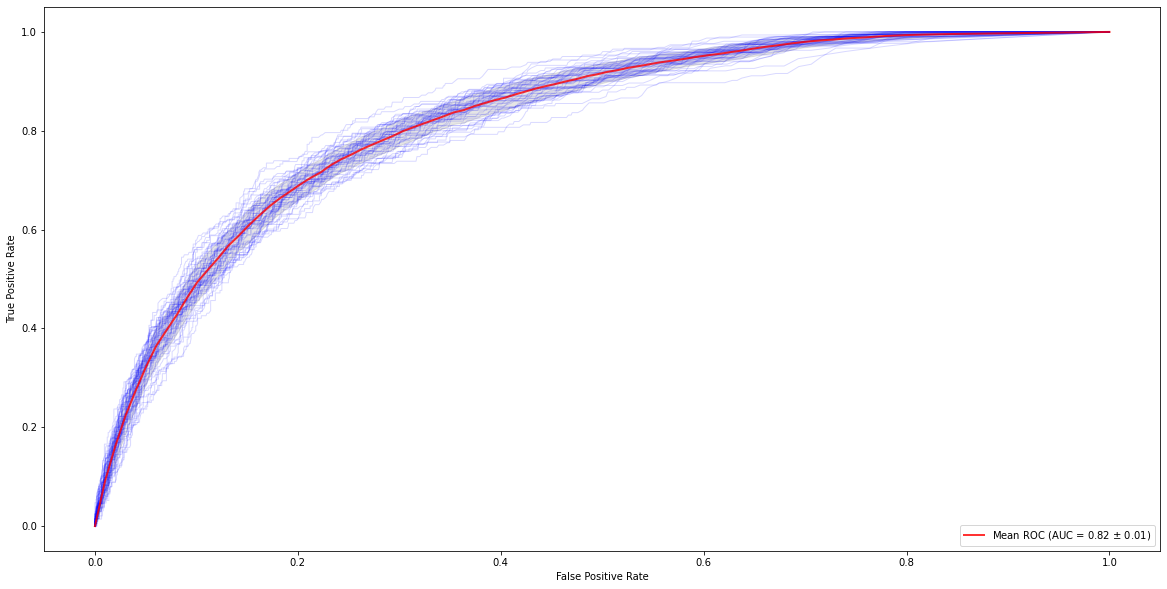

In [14]:
# #- create plot instance
fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

#- go through all n model executions
for n in range(config.getint('settings', 'n_runs')):
    
    if config.getboolean('general', 'verbose'):
        print('run {} of {}'.format(n+1, config.getint('settings', 'n_runs')) + os.linesep)

    #- run machine learning model and return outputs
    X_df, y_df, eval_dict = pipeline.run_reference(X, Y, config, scaler, clf, out_dir)
    
    #- select sub-dataset with only datapoints with observed conflicts
    X1_df, y1_df = utils.get_conflict_datapoints_only(X_df, y_df)
    
    #- append per model execution
    out_X_df = evaluation.fill_out_df(out_X_df, X_df)
    out_y_df = evaluation.fill_out_df(out_y_df, y_df)
    out_dict = evaluation.fill_out_dict(out_dict, eval_dict)

    #- plot ROC curve per model execution
    tprs, aucs = plots.plot_ROC_curve_n_times(ax1, clf, X_df.to_numpy(), y_df.y_test.to_list(),
                                                                  trps, aucs, mean_fpr)

#- plot mean ROC curve
plots.plot_ROC_curve_n_mean(ax1, tprs, aucs, mean_fpr)

## Model evaluation

### For all data points

During the model runs, the computed model evaluation scores per model execution were stored to a dictionary. Currently, the evaluation scores used are:

* [**Accuracy**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): the fraction of correct predictions;
* [**Precision**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html): the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative;
* [**Recall**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html): the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples;
* [**F1 score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): the F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0;
* [**Cohen-Kappa score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html): is used to measure inter-rater reliability. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance.
* [**Brier score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html): the smaller the Brier score, the better, hence the naming with “loss”. The lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier loss score is relatively sensitive for imbalanced datasets;
* [**ROC score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): a value of 0.5 suggests no skill, e.g. a curve along the diagonal, whereas a value of 1.0 suggests perfect skill, all points along the left y-axis and top x-axis toward the top left corner. A value of 0.0 suggests perfectly incorrect predictions. Note that the ROC score is relatively insensitive for imbalanced datasets.

Let's check the mean scores over all runs:

In [15]:
for key in out_dict:
    
    print('average {0} of run with {1} repetitions is {2:0.3f}'.format(key, config.getint('settings', 'n_runs'), np.mean(out_dict[key])))

average Accuracy of run with 50 repetitions is 0.851
average Precision of run with 50 repetitions is 0.572
average Recall of run with 50 repetitions is 0.272
average F1 score of run with 50 repetitions is 0.368
average Cohen-Kappa score of run with 50 repetitions is 0.296
average Brier loss score of run with 50 repetitions is 0.108
average ROC AUC score of run with 50 repetitions is 0.825


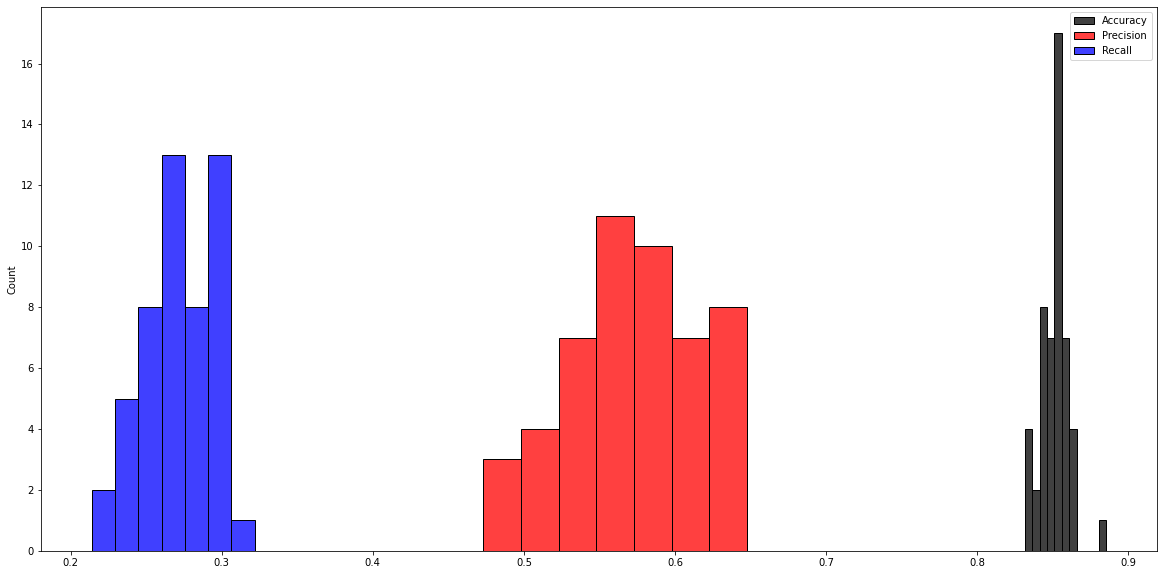

In [16]:
plots.metrics_distribution(out_dict, figsize=(20, 10));

Based on all data points, the [**confusion matrix**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) can be plotted. This is a relatively straightforward way to visualize how good the classifier values are predicted by the model.

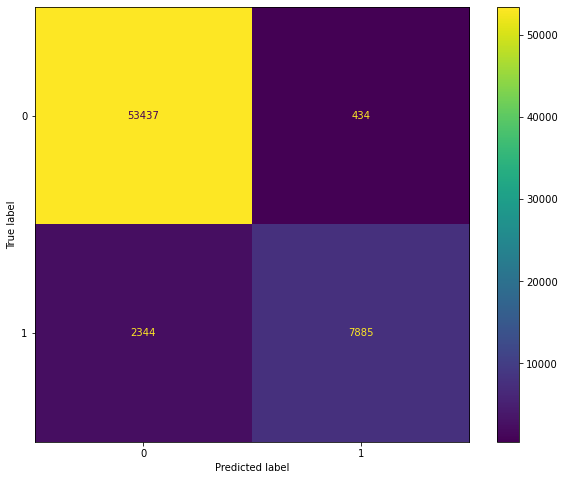

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
metrics.plot_confusion_matrix(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax);

### Per unique polygon

Thus far, we merely looked at numerical scores. This of course tells us a lot about the quality of the machine-learning model and its predictions, but not so much about how this looks like spatially. We therefore combine the observations and predictions made with the associated polygons based on a 'global' dataframe functioning as a look-up table. By this means, each model output can be connected to its polygon using a unique ID.

In [32]:
out_y_df

,ID,geometry,y_test,y_pred,correct_pred
0,979,"POLYGON ((4.626286105919121 13.73700998692141,...",1,0,0
1,993,"POLYGON ((31.28046433346225 21.99947826570946,...",0,0,1
2,1588,"POLYGON ((30.21708232075323 -15, 30.2178569385...",0,0,1
3,100,"POLYGON ((32.56948144761077 30.10000000019988,...",0,0,1
4,1020,"POLYGON ((31.70969237560269 16.65842461160656,...",1,0,0
...,...,...,...,...,...
64095,1581,"POLYGON ((34.17973233711044 -17.5, 34.19453423...",0,0,1
64096,120,POLYGON ((20.99766183952232 -20.35426497964505...,0,0,1
64097,98,"POLYGON ((43.22852866366696 11.41488920617195,...",0,0,1
64098,1015,"POLYGON ((27.22388839173595 11.60666664494977,...",1,0,0


In [18]:
df_hit, gdf_hit = evaluation.polygon_model_accuracy(out_y_df, global_df, out_dir=None)

In [29]:
print('we consider {} polygons in our analysis'.format(len(df_hit)))

we consider 267 polygons in our analysis


In [31]:
df_hit

,ID_count,correct_pred,nr_test_confl,nr_pred_confl,chance_correct_pred,chance_correct_confl_pred,geometry,category
ID,,,,,,,,
1100,282,282,0,0,1.000000,0.000000,"POLYGON ((25.22500 -24.62495, 25.44182 -24.685...",HL
872,279,279,0,0,1.000000,0.000000,"MULTIPOLYGON (((-3.50000 35.20236, -3.49085 35...",HL
109,272,229,15,28,0.841912,0.102941,"POLYGON ((38.45724 17.90429, 38.45254 17.89982...",LH
1522,271,267,0,4,0.985240,0.014760,"POLYGON ((-2.25417 14.23127, -2.25417 14.22917...",HL
987,270,210,71,41,0.777778,0.151852,"MULTIPOLYGON (((13.72011 10.88396, 13.71620 10...",LH
...,...,...,...,...,...,...,...,...
55,217,217,0,0,1.000000,0.000000,"POLYGON ((29.61704 30.50417, 29.61702 30.46303...",HL
869,216,183,31,2,0.847222,0.009259,"POLYGON ((18.83048 30.34501, 18.79995 29.95697...",LH
974,216,216,0,0,1.000000,0.000000,"MULTIPOLYGON (((-4.47759 12.72826, -4.47539 12...",HL


First, let's have a look at how often each polygon occurs in the all test samples, i.e. those obtained by appending the test samples per model execution. Besides, the overall relative distribution is visualized.

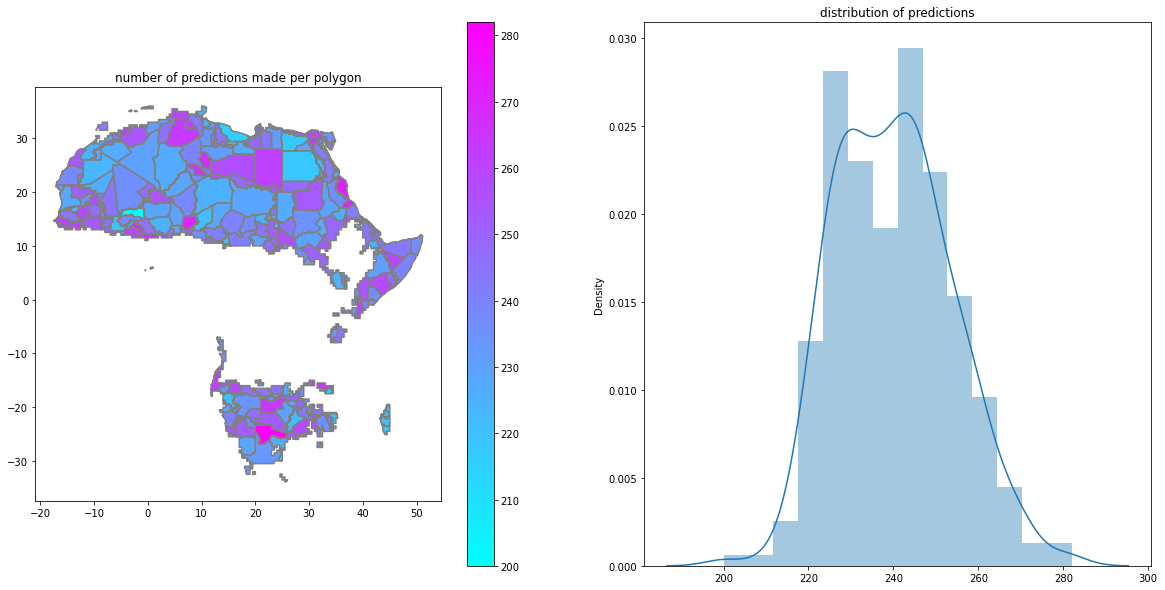

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='ID_count', legend=True, cmap='cool')
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
sbs.distplot(df_hit.ID_count.values, ax=ax2)
ax2.set_title('distribution of predictions');

By repeating the model n times, the aim is to represent all polygons in the resulting test sample. The fraction is computed below. 

Note that is should be close to 100 % but may be slightly less. This can happen if input variables have no data for one polygon, leading to a removal of those polygons from the analysis. Or because some polygons and input data may not overlap.

In [20]:
print('{0:0.2f} % of all active polygons are considered in test sample'.format(len(gdf_hit)/len(selected_polygons_gdf)*100))

97.45 % of all active polygons are considered in test sample


By aggregating results per polygon, we can now assess model output spatially. Three main aspects are presented here:

1. The chance of a correct prediction, defined as the ratio of number of correct predictions made to overall number of predictions made;
2. The total number of conflicts in the test data;
3. The chance of conflict, defined as the ration of number of conflict predictions to overall number of predictions made.

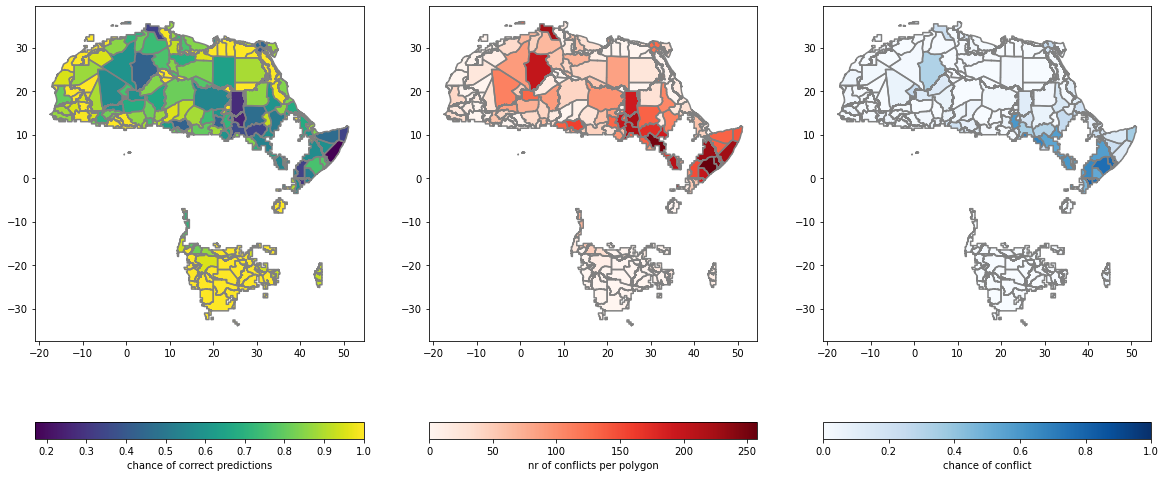

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='chance_correct_pred', legend=True, 
             legend_kwds={'label': "chance of correct predictions", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
gdf_hit.plot(ax=ax2, column='nr_test_confl', legend=True, cmap='Reds', 
             legend_kwds={'label': "nr of pred. conflicts per polygon", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax2, color='0.5')
gdf_hit.plot(ax=ax3, column='chance_correct_confl_pred', legend=True, cmap='Blues', vmin=0, vmax=1, 
             legend_kwds={'label': "chance of conflict", 'orientation': "horizontal"})
selected_polygons_gdf.boundary.plot(ax=ax3, color='0.5');

To get the variation of CCP (chance of corret prediction) per polygon, we split up the entire output data in 10 parts and calcualte mean, median, and standard deviation of CCP.

In [22]:
gdf_CCP = evaluation.calc_kFold_polygon_analysis(out_y_df, global_df, out_dir=None)

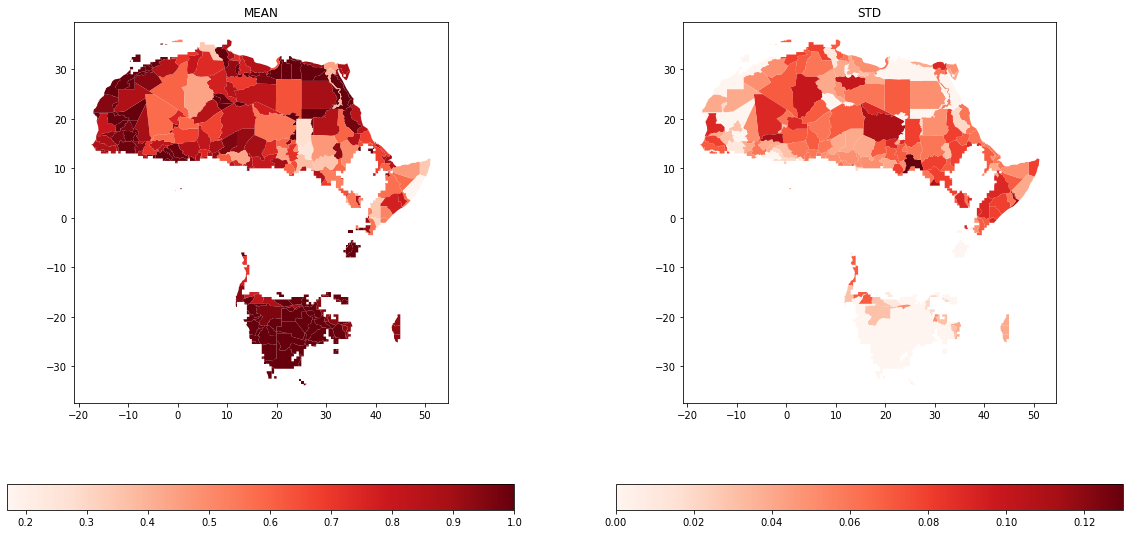

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_CCP.plot(column='mean_CCP', ax=ax1, cmap='Reds', legend=True, legend_kwds={'orientation': "horizontal"})
ax1.set_title('MEAN')
gdf_CCP.plot(column='std_CCP', ax=ax2, cmap='Reds', legend=True, legend_kwds={'orientation': "horizontal"})
ax2.set_title('STD');

To understand to what extent the model accuracy (i.e. hits) may depend on the number of predictions made per polygon or other factors, we plot some simple scatter plots.

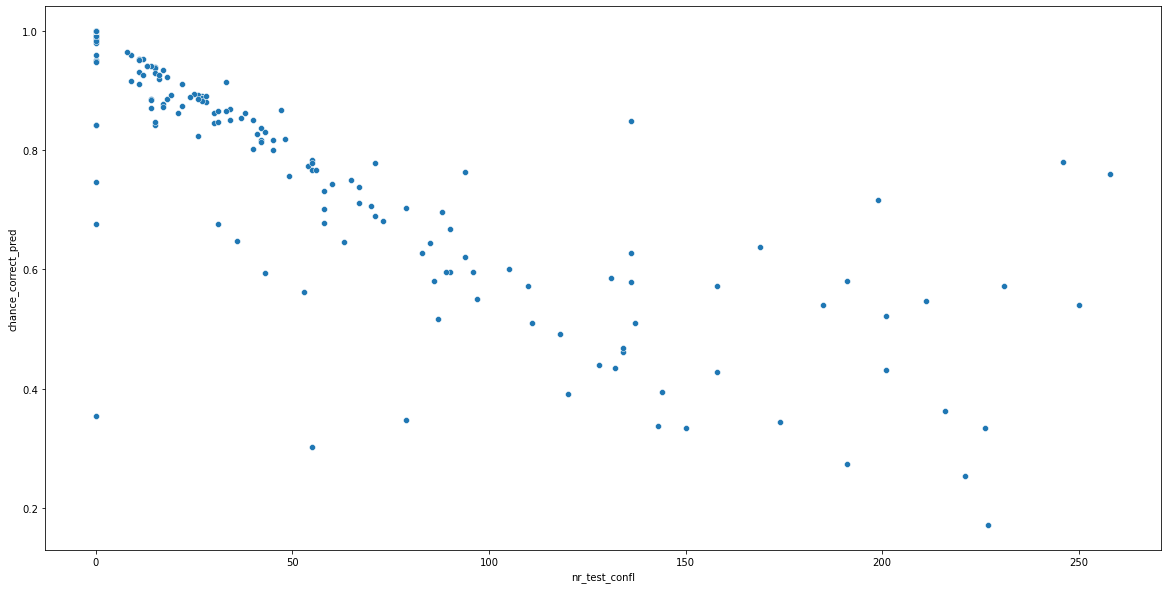

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sbs.scatterplot(data=df_hit, x='nr_test_confl', y='chance_correct_pred', ax=ax)

Up to know, we looked at two or more indicators of how the model performed and other statistical analyses per polygon. It's now time to come up with an indicator for which polygons we 'trust' the model.

Thus, we compute the median of the average hit accuracy of all polygons. This allows for dividing the polygons in the 50 % with an average hit accuracy above the median, and the other 50 % below it. These are our main categories:

* 'H': upper 50 % of average hit accuracy;
* 'L': lower 50 % of average hit accuracy.

In addition, we may want to know how this categorization depends on the number of conflicts in a polygon. For example, wich polygons have a high accuracy with lots of conflicts? For these polygons, we could assume that the model robustly succeeds in predicting conflict. To that end, we also compute the median number of conflicts per polygon.

This yields four sub-categories:

* 'HH': upper 50 % of average hit accuracy and upper 50 % of number of conflicts;
* 'HL': upper 50 % of average hit accuracy, but then with lower 50 % of number of conflicts;
* 'LH': lower 50 % of average hit accuracy and upper 50 % of number of conflicts;
* 'LL': lower 50 % of average hit accuracy, but then with lower 50 % of number of conflicts.

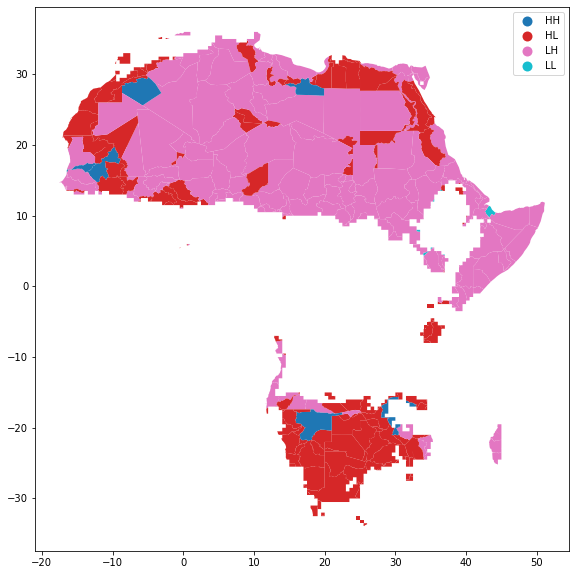

In [25]:
plots.polygon_categorization(gdf_hit, category='sub', figsize=(20, 10), legend=True);

Last, we can determine the relative importance of each feature, that is variable.

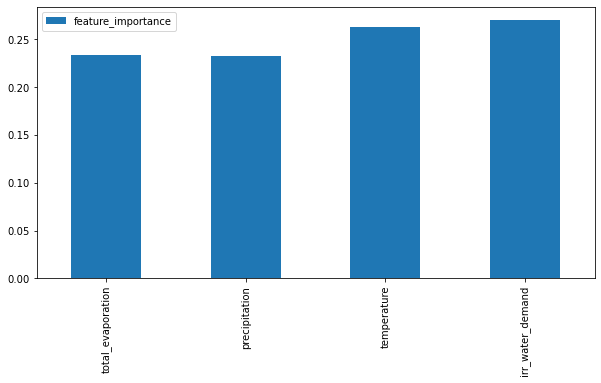

In [26]:
plots.factor_importance(clf, config, out_dir, figsize=(10, 5));